<a href="https://colab.research.google.com/github/Vsnikhilmaheswar/deepfake_not_final/blob/main/deepfakes_(4)_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install dependencies



In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle
!pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 789.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.6-py3-none-any.whl size=111941 sha256=f45f8e012785b7202cacce4dc9748a1009faa39e521836018565caba2490c3d2
  Stored in directory: /root/.cache/pip/wheels/53/34/8c/8ca3450d17206d9e37e1ee3aeb47cbb2873d22a9e0c60eb137
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=f15967323201aa8ffcb1101c16e3b2de8da8e75e01127c27d4c32085111a8c21
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully bui

### Download Dataset

here we use kaggle api to download dataset

In [2]:
# #upload api key
# from google.colab import files
# files.upload()

{}

In [ ]:
# # prepare for api command and give permission for read and write
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle
# !rm -rf kaggle.json
# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# # apply Api command
# !kaggle competitions download -c deepfake-detection-challenge

 99% 4.11G/4.13G [00:32<00:00, 221MB/s]
100% 4.13G/4.13G [00:32<00:00, 135MB/s]


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# #unzip dataset
# !unzip /content/deepfake-detection-challenge.zip &> /dev/null
# !rm -rf /content/deepfake-detection-challenge.zip

### Import Libraries

In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
import face_recognition
from skimage.transform import resize
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import resnet50
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop ,SGD , Adam
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import seaborn as sns
from datetime import datetime
start = datetime.now()

### Analyze dataset

In [6]:
# get metadata info
train_sample_metadata = pd.read_json('/content/metadata.json').T
train_sample_metadata.head()

label  split        original
aagfhgtpmv.mp4  FAKE  train  vudstovrck.mp4
aapnvogymq.mp4  FAKE  train  jdubbvfswz.mp4
abarnvbtwb.mp4  REAL  train            None
abofeumbvv.mp4  FAKE  train  atvmxvwyns.mp4
abqwwspghj.mp4  FAKE  train  qzimuostzz.mp4

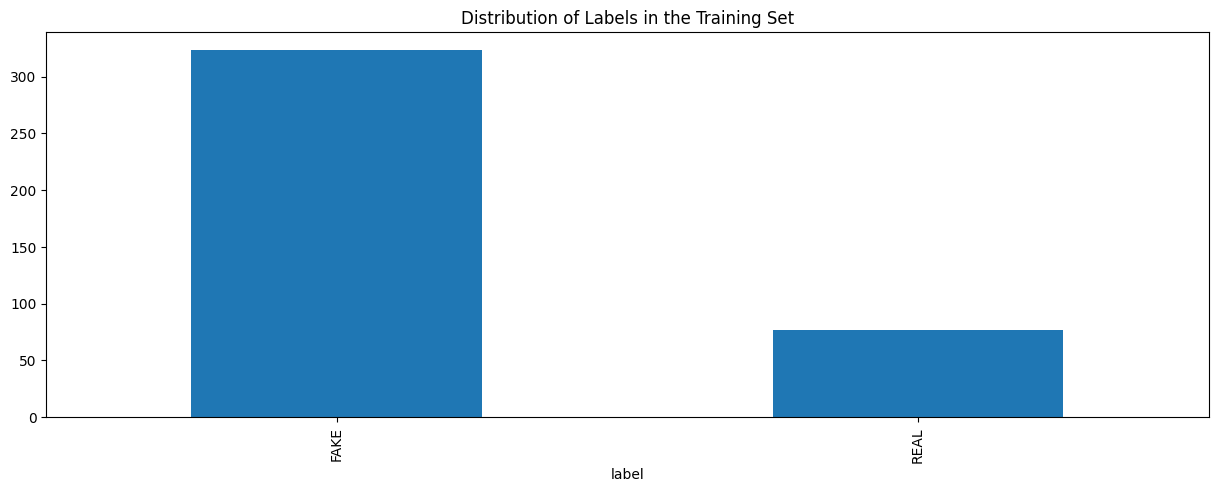

In [7]:
# plot Distribution of Labels in the Training Set
train_sample_metadata.groupby('label')['label'].count().plot(figsize=(15, 5), kind='bar', title='Distribution of Labels in the Training Set')
plt.show()

In [9]:
!unzip /content/drive/MyDrive/faces.zip &> /dev/null

In [8]:
video_file = '/content/train_sample_videos/abarnvbtwb.mp4'
cap = cv.VideoCapture(video_file)
success, image = cap.read()
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
cap.release()
plt.imshow(image)

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


### Dataset prepration

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!mkdir /content/drive/MyDrive/faces
!mkdir /content/drive/MyDrive/faces/fake
!mkdir /content/drive/MyDrive/faces/real

mkdir: cannot create directory ‘/content/drive/MyDrive/faces’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/faces/fake’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/faces/real’: File exists


In [ ]:
labels = []
data = []
train_dir = 'train_sample_videos'
fake_name = '/content/drive/MyDrive/faces/fake'
real_name = '/content/drive/MyDrive/faces/real'
for fn in train_sample_metadata.index:
    label = train_sample_metadata.loc[fn]['label']
    video_file = os.path.join(train_dir,fn)
    cap = cv.VideoCapture(video_file)
    length = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
    for k in range(0,length ,30):
      success, image = cap.read()
      try:
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
      except:
        continue
      face_locations = face_recognition.face_locations(image)
      if len(face_locations) > 0:
        face_location = face_locations[0]
        top, right, bottom, left = face_location
        face_image = image[top:bottom, left:right]
        face_image = resize(face_image,(224,224))
        if label == 'FAKE':
          plt.imsave(os.path.join(fake_name,fn.split('.')[0])+str(k)+'.png',face_image)
        else:
          plt.imsave(os.path.join(real_name,fn.split('.')[0])+str(k)+'.png',face_image)
        data.append(face_image)
        labels.append(label)
    cap.release()
labels = np.array(labels)
data = np.array(data)



In [10]:
# read data from google drive folders

path1 ='/content/faces/fake'
path2 ='/content/faces/real'
list1=os.listdir(path1)
list2=os.listdir(path2)
data = []
labels =[]
for k in list1[:200]:
    # print(k)
    try:
      img = plt.imread(os.path.join(path1,k))[:,:,:3]
    except:
      continue
    data.append(img)
    labels.append('fake')

for k in list2[:200]:
    # print(k)
    try:
      img = plt.imread(os.path.join(path2,k))[:,:,:3]
    except:
      continue
    data.append(img)
    labels.append('real')

labels = np.array(labels)
data = np.array(data)

In [11]:
# encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

### cnn models

27018416/27018416 [==============================] - 2s 0us/step
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.871718 to fit



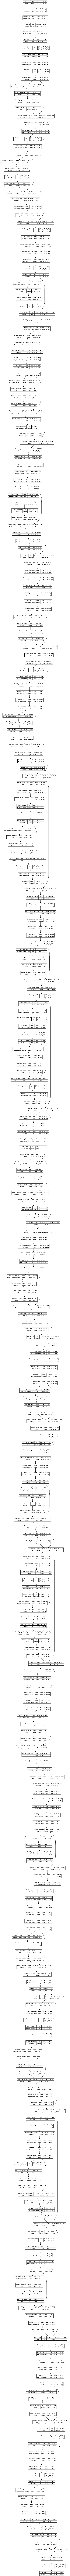

In [ ]:
# download  model
enet_bmodel =efficientnet.EfficientNetB1(input_shape=(224,224,3),include_top=False,weights='imagenet')
# display summary of base model
plot_model(enet_bmodel,show_shapes=True)

58889256/58889256 [==============================] - 4s 0us/step


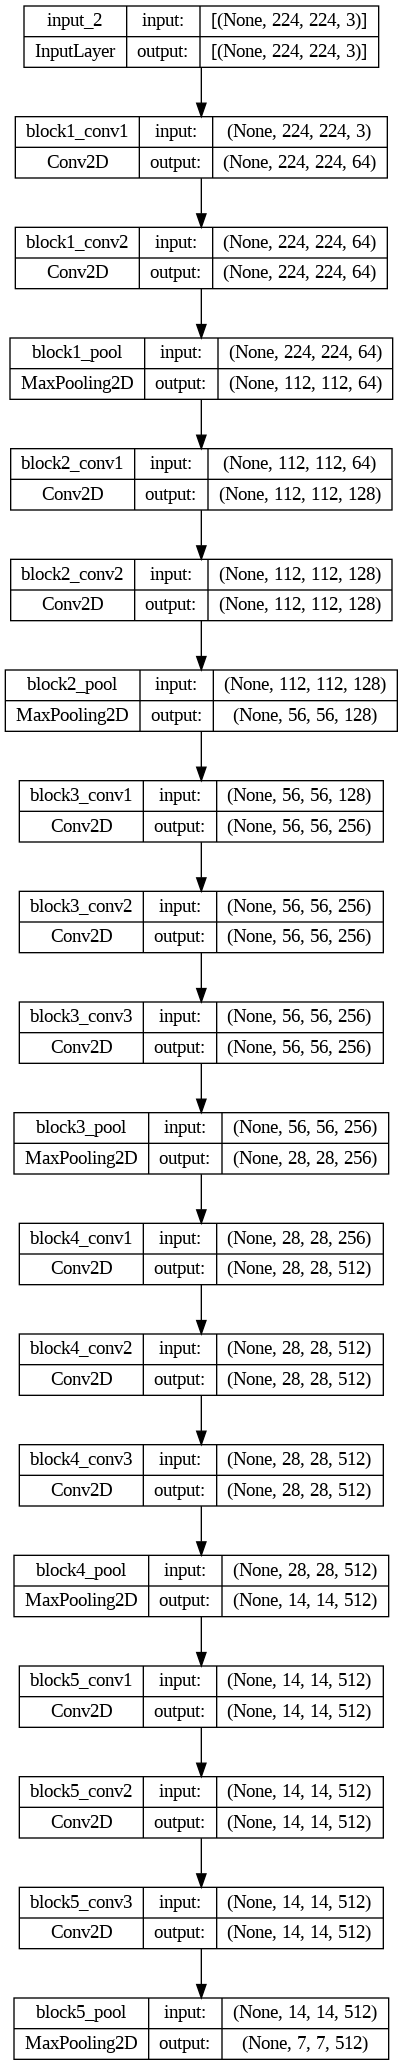

In [ ]:
# download  model
vgg_bmodel =VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')
# display summary of base model
plot_model(vgg_bmodel,show_shapes=True)

94765736/94765736 [==============================] - 1s 0us/step


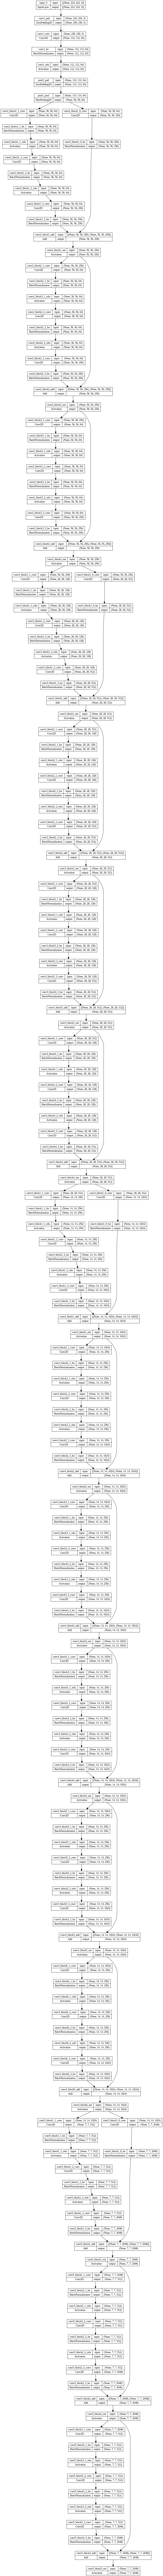

In [ ]:

# # download  model
# rnet_bmodel =resnet50.ResNet50(input_shape=(224,224,3),include_top=False,weights='imagenet')
# # display summary of base model
# plot_model(rnet_bmodel,show_shapes=True)

### feature extraction

In [12]:
enet_bmodel =efficientnet.EfficientNetB1(input_shape=(224,224,3),include_top=False,weights='imagenet')
vgg_bmodel =VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')
# rnet_bmodel =resnet50.ResNet50(input_shape=(224,224,3),include_top=False,weights='imagenet')
vgg_model = Model(inputs=vgg_bmodel.layers[0].input,outputs=vgg_bmodel.layers[-1].output)
# resenet
# rnet_model = Model(inputs=rnet_bmodel.layers[0].input,outputs=rnet_bmodel.layers[-1].output)
# efficient net
enet_model = Model(inputs=enet_bmodel.layers[0].input,outputs=enet_bmodel.layers[-1].output)

58889256/58889256 [==============================] - 0s 0us/step


In [13]:
def feature_extraction(inp):
  inp1 = np.expand_dims(inp,axis=0)
  fet1 = vgg_model.predict(inp1)
  fet1 = np.array(fet1).flatten().reshape(49,512)
  pca = PCA(n_components=20)
  nfet1 = pca.fit_transform(fet1).flatten()

  # fet2 = rnet_model.predict(inp1)
  # fet2 = np.array(fet2).flatten().reshape(49,2048)
  # nfet2 = pca.fit_transform(fet2).flatten()

  fet3 = enet_model.predict(inp1)
  fet3 = np.array(fet3).flatten().reshape(49,1280)
  nfet3 = pca.fit_transform(fet3).flatten()
  fet =np.concatenate([nfet1,nfet3])
  return fet


In [14]:
features = []
for inp in data:
  features.append(feature_extraction(inp))


1/1 [==============================] - 0s 61ms/step


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

features = np.array(features)
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

# Define ensemble classifiers (you can use different classifiers here)
clf1 = RandomForestClassifier()
clf2 = GradientBoostingClassifier()
clf3 = SVC(probability=True)

# Train ensemble model
ensemble_model = VotingClassifier(estimators=[('rf', clf1), ('gb', clf2), ('svc', clf3)], voting='soft')
ensemble_model.fit(X_train, y_train)

# Evaluate ensemble model
y_pred_train = ensemble_model.predict(X_train)
y_pred_val = ensemble_model.predict(X_val)

train_accuracy = accuracy_score(y_train, y_pred_train)
val_accuracy = accuracy_score(y_val, y_pred_val)

print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

Training Accuracy: 1.0
Validation Accuracy: 0.775


In [23]:
# Assuming you have a single test image file path stored in 'test_image_path'

# Read the test image
test_image = plt.imread('/content/faces/fake/bopqhhalml0.png')

# Preprocess the test image if necessary
# Example: Resize the image to match the input size expected by your model
test_image = cv.cvtColor(test_image, cv.COLOR_BGR2RGB)

# Extract features from the preprocessed test image
test_features = feature_extraction(test_image)

# Reshape the features into a 2D array
test_features = test_features.reshape(1, -1)  # Reshape into a single-sample 2D array

# Make prediction
prediction = ensemble_model.predict(test_features)

# Decode the predicted label if necessary
predicted_class = label_encoder.inverse_transform(prediction)

# Print prediction
print("Predicted Class:", predicted_class)


1/1 [==============================] - 0s 119ms/step
Predicted Class: ['fake']


In [24]:
end = datetime.now()
end-start

datetime.timedelta(seconds=1993, microseconds=811215)

In [25]:
import joblib

# Save the individual classifiers
joblib.dump(clf1, 'clf1_model.pkl')
joblib.dump(clf2, 'clf2_model.pkl')
joblib.dump(clf3, 'clf3_model.pkl')

# Save the label encoder
joblib.dump(label_encoder, 'label_encoder.pkl')


['label_encoder.pkl']

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
import face_recognition
from skimage.transform import resize
from skimage.color import rgb2gray
video_file = 'asvcrfdpnq.mp4'
photo = 'photo'
cap = cv.VideoCapture(video_file)
length = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
for k in range(0,length ,30):
      success, image = cap.read()
      try:
         image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
      except:
        continue
      face_locations = face_recognition.face_locations(image)
      if len(face_locations) > 0:
        face_location = face_locations[0]
        top, right, bottom, left = face_location
        face_image = image[top:bottom, left:right]
        face_image = resize(face_image,(224,224))
        plt.imsave(os.path.join(photo, os.path.splitext(os.path.basename(video_file))[0]) + str(k) + '.png', face_image)
cap.release()

In [ ]:
img = plt.imread('/content/drive/MyDrive/faces/fake/aagfhgtpmv0.png')[:,:,:3]
f = feature_extraction(img)
result = clf.predict([f])
if result[0]:
  print('fake')
else:
  print('real')



1/1 [==============================] - 0s 105ms/step
fake


In [ ]:
img = plt.imread('/content/drive/MyDrive/faces/real/ciyoudyhly120.png')[:,:,:3]
f = feature_extraction(img)
result = clf.predict([f])
if result[0]:
  print('fake')
else:
  print('real')

1/1 [==============================] - 0s 89ms/step
real


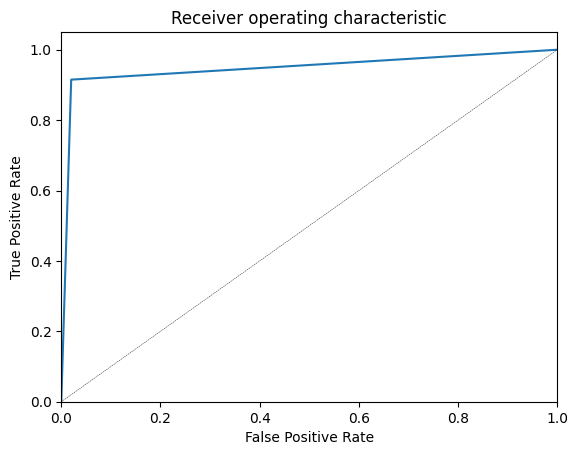

In [ ]:
# from sklearn.metrics import roc_curve
# fpr, tpr, _ = roc_curve(labels, predictions)
# plt.figure()
# plt.plot(fpr, tpr)
# plt.plot([0.0, 1.0], [0.0, 1.0], ls='--', lw=0.3, c='k')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.show()